# Tuning curve analysis of VGG16 codebooks

## Imports

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
# compute
import numpy as np
import pandas as pd

# data io
import glob
import deepdish as dd
import sys
sys.path.append('../')

# image
import cv2

# plot
import matplotlib.pyplot as plt
%matplotlib inline

# spykes
from spykes.neuropop import NeuroPop
from spykes.neurovis import NeuroVis

# stats
from scipy.stats import circmean

# machine learning
import xgboost as xgb

# local
import V4pyutils as V4

/opt/anaconda/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using Theano backend.
Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5103)
/opt/anaconda/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


## Load merged sessions

### Filenames

In [2]:
h5path = '../V4pydata/H5data/M3/'
data = pd.read_excel('/home/klab/Projects/02-V4py/V4py/V4pydata/natural_artificial.xlsx')
data_M3 = data[data['Animal']=='M3']
data_M3.head()

,Animal,Natural,Hue,Ori,RF
7,M3,Ro150125_s83a_FreeViewPic_0004,Ro150126_s83a_huecircle_0003,Ro150126_s83a_v4fv_orituning_0002,Ro150126_s83a_rfMapping_0001
8,M3,Ro150125_s83a_FreeViewPic_0005,Ro150126_s83a_huecircle_0003,Ro150126_s83a_v4fv_orituning_0002,Ro150126_s83a_rfMapping_0001
9,M3,Ro150127_s84a_FreeViewPic_0001,Ro150127_s84a_huecircle_0003,Ro150127_s84a_v4fv_orituning_0002,Ro150127_s84a_rfMapping_0001
10,M3,Ro150128_s85a_FreeViewPic_0001,Ro150128_s85a_huecircle_0003,Ro150128_s85a_v4fv_orituning_0002,Ro150128_s85a_rfMapping_0001
11,M3,Ro150129_s86a_FreeViewPic_0001,Ro150129_s86a_huecircle_0003,Ro150129_s86a_v4fv_orituning_0002,Ro150129_s86a_rfMapping_0001


### All sessions

In [3]:
df = pd.read_pickle('../02-preprocessed_data/merged_art_data_across_sessions_orientation')

# Correct for orientation angle > 180 deg.
df['predictors.ori'] = np.where(df['predictors.ori'] >= 180.0,
                                df['predictors.ori'] - 180.0,
                                df['predictors.ori'])
df['predictors.ori_prev'] = np.where(df['predictors.ori_prev'] >= 180.0,
                                     df['predictors.ori_prev'] - 180.0,
                                     df['predictors.ori_prev'])
df.head()


,predictors.onset_times,predictors.offset_times,predictors.col,predictors.row,predictors.ori,predictors.ori_prev,predictors.stim_dur,predictors.off_to_onset_times,spikes.0101,spikes.0201,...,spikes.9002,spikes.9100,spikes.9102,spikes.9200,spikes.9202,spikes.9300,spikes.9400,spikes.9600,session.name,session.number
0,17.794800,18.079600,521.0,521.0,112.0,-999.0,0.284800,-999.000000,NaN,NaN,...,NaN,11.0,NaN,11.0,NaN,NaN,NaN,3.0,../V4pydata/H5data/M3/Ro150126_s83a_v4fv_oritu...,0
1,18.398067,18.690333,590.0,590.0,157.0,112.0,0.292267,0.318467,NaN,NaN,...,NaN,11.0,NaN,11.0,NaN,NaN,NaN,2.0,../V4pydata/H5data/M3/Ro150126_s83a_v4fv_oritu...,0
2,19.011833,19.299400,670.0,670.0,67.0,157.0,0.287567,0.321500,NaN,NaN,...,NaN,8.0,NaN,8.0,NaN,NaN,NaN,4.0,../V4pydata/H5data/M3/Ro150126_s83a_v4fv_oritu...,0
3,19.618200,19.909533,641.0,641.0,67.0,67.0,0.291333,0.318800,NaN,NaN,...,NaN,7.0,NaN,7.0,NaN,NaN,NaN,1.0,../V4pydata/H5data/M3/Ro150126_s83a_v4fv_oritu...,0
4,20.248333,20.545200,621.0,621.0,112.0,67.0,0.296867,0.338800,NaN,NaN,...,NaN,2.0,NaN,2.0,NaN,NaN,NaN,3.0,../V4pydata/H5data/M3/Ro150126_s83a_v4fv_oritu...,0


### Merging table

In [4]:
df_neurons = pd.read_pickle('../02-preprocessed_data/data_to_combine_across_sessions')
df_neurons.head(10)

,name,art_sessions,art_filenames,nat_sessions,nat_filenames
0,spikes.0101,"[2, 3]","[Ro150127_s84a_huecircle_0003, Ro150128_s85a_h...",[4],[Ro150129_s86a_FreeViewPic_0001]
1,spikes.0301,"[8, 9]","[Ro150211_s88a_huecircle_0003, Ro150212_289a_h...","[11, 12]","[Ro150216_s91a_FreeViewPic_0004, Ro150216_s91a..."
2,spikes.0500,"[3, 4, 5]","[Ro150128_s85a_huecircle_0003, Ro150129_s86a_h...","[5, 6]","[Ro150129_s86a_FreeViewPic_0005, Ro150210_s87a..."
3,spikes.0500,"[4, 5, 6]","[Ro150129_s86a_huecircle_0003, Ro150129_s86a_h...","[6, 7, 8]","[Ro150210_s87a_FreeViewPic_manyimage_0004, Ro1..."
4,spikes.0600,"[2, 3, 4, 5]","[Ro150127_s84a_huecircle_0003, Ro150128_s85a_h...","[4, 5, 6]","[Ro150129_s86a_FreeViewPic_0001, Ro150129_s86a..."
5,spikes.0700,"[0, 1, 2, 3]","[Ro150126_s83a_huecircle_0003, Ro150126_s83a_h...","[2, 3, 4]","[Ro150127_s84a_FreeViewPic_0001, Ro150128_s85a..."
6,spikes.0700,"[4, 5]","[Ro150129_s86a_huecircle_0003, Ro150129_s86a_h...",[6],[Ro150210_s87a_FreeViewPic_manyimage_0004]
7,spikes.0700,"[7, 8]","[Ro150211_s88a_huecircle_0003, Ro150211_s88a_h...",[10],[Ro150213_s90a_FreeViewPic_0004]
8,spikes.0900,"[0, 1, 2, 3, 4, 5]","[Ro150126_s83a_huecircle_0003, Ro150126_s83a_h...","[2, 3, 4, 5, 6]","[Ro150127_s84a_FreeViewPic_0001, Ro150128_s85a..."
9,spikes.0900,"[3, 4, 5, 6, 7]","[Ro150128_s85a_huecircle_0003, Ro150129_s86a_h...","[5, 6, 7, 8, 9]","[Ro150129_s86a_FreeViewPic_0005, Ro150210_s87a..."


## Simulated neuron and VGG16: tuning curves

### Instantiate vgg models

In [74]:
#vgg_model = V4.transfer_learning(architecture_file='../02-preprocessed_data/vgg16_architecture.json',
#                                 weights_file='../02-preprocessed_data/vgg16_weights.h5',
#                                 n_pops=0)
#vgg_model = V4.transfer_learning(architecture_file='../02-preprocessed_data/vgg16_architecture.json',
#                                 weights_file='../02-preprocessed_data/vgg16_weights.h5',
#                                 n_pops=1)
#vgg_model = V4.transfer_learning(architecture_file='../02-preprocessed_data/vgg16_architecture.json',
#                                 weights_file='../02-preprocessed_data/vgg16_weights.h5',
#                                 n_pops=3)
vgg_model = V4.transfer_learning(architecture_file='../02-preprocessed_data/vgg16_architecture.json',
                                 weights_file='../02-preprocessed_data/vgg16_weights.h5',
                                 n_pops=5)


### Extract art features for gratings

In [9]:
np.unique(df['predictors.ori'])

array([   0.,   22.,   45.,   67.,   90.,  112.,  135.,  157.])

#### Orientation

In [10]:
def make_sine_grating(n_pixels=224, theta=0, spatial_freq=0.03, phase=0):
    
    # Design the grating
    [x, y] = np.meshgrid(np.arange(n_pixels), np.arange(n_pixels))
    theta = 180. - theta
    x_theta = x * np.cos(theta / 180. * np.pi) + y * np.sin(theta / 180. * np.pi)
    y_theta = -x * np.sin(theta / 180. * np.pi) + y * np.cos(theta / 180. * np.pi)
    grating = (1. + np.cos(2 * np.pi * spatial_freq * x_theta + phase / 180. * np.pi))/ 2.
    
    # Make it into an image
    G = np.zeros((n_pixels, n_pixels, 3))
    G[:, :, 0] = grating * 255.
    G[:, :, 1] = grating * 255.
    G[:, :, 2] = grating * 255.    
    return np.uint8(G)

In [11]:
ori = 180. * np.random.rand(1000,1)
Xgrating_vgg = list()
# Extract vgg features for oriented gratings
Xgrating_vgg = list()
for a, ang in enumerate(ori):
    G = make_sine_grating(theta=ang, phase=0.)
    G_for_vgg = V4.prepare_image_for_vgg(G)
    Xgrating_vgg.append(np.squeeze(vgg_model.predict(G_for_vgg)))
Xgrating_vgg = np.array(Xgrating_vgg)

In [12]:
Xgrating_vgg.shape

(1000, 1000)

#### Hue

In [75]:
hue = 360. * np.random.rand(1000,1)
rgb_list = list()

Xplain_vgg = list()
stimpath = '../V4pydata'

#for stim_id in range(360):
for a, ang in enumerate(hue):
    imname = '/stimuli/M3/Hues/img%03d.jpg' % np.floor(ang)
    filename = stimpath + imname
    I = cv2.imread(filename)
    I_for_vgg = V4.prepare_image_for_vgg(I)
    rgb_list.append(I[0,0,:][::-1])
    Xplain_vgg.append(np.squeeze(vgg_model.predict(I_for_vgg)))
Xplain_vgg = np.array(Xplain_vgg)

In [76]:
Xplain_vgg.shape

(1000, 25088)

### Visualize using manifold dimensionality reduction

In [77]:
from sklearn.manifold import TSNE, MDS, SpectralEmbedding

In [78]:
#tsne = TSNE(n_components=2)
se = SpectralEmbedding(n_components=2)
X_lowd = se.fit_transform(Xplain_vgg)
#mds.fit(Xplain_vgg)

#### L8

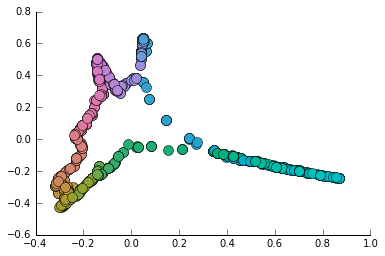

In [61]:
plt.figure()
ax = plt.subplot(111)
for im in range(X_lowd.shape[0]):
    ax.plot(X_lowd[im, 0], X_lowd[im, 1], 'o', ms=10, c=rgb_list[im].astype(float) / 255.0)
V4.simpleaxis(ax)
#plt.axis([-50, 50, -50, 50])
plt.show()

#### L7

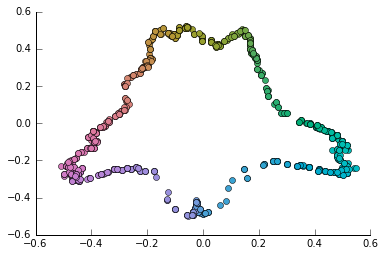

In [67]:
plt.figure()
ax = plt.subplot(111)
for im in range(X_lowd.shape[0]):
    ax.plot(X_lowd[im, 0], X_lowd[im, 1], 'o', c=rgb_list[im].astype(float) / 255.0)
V4.simpleaxis(ax)
plt.show()

#### L6

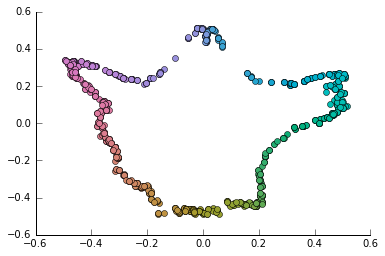

In [73]:
plt.figure()
ax = plt.subplot(111)
for im in range(X_lowd.shape[0]):
    ax.plot(X_lowd[im, 0], X_lowd[im, 1], 'o', c=rgb_list[im].astype(float) / 255.0)
V4.simpleaxis(ax)
plt.show()

#### L5

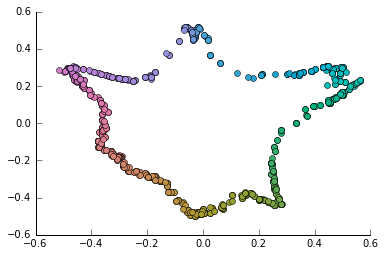

In [80]:
plt.figure()
ax = plt.subplot(111)
for im in range(X_lowd.shape[0]):
    ax.plot(X_lowd[im, 0], X_lowd[im, 1], 'o', c=rgb_list[im].astype(float) / 255.0)
V4.simpleaxis(ax)
plt.show()

### Simulate a cosine tuned neuron

In [13]:
from pyglmnet import GLM
glm = GLM(distr='poissonexp')
covars = np.concatenate((np.cos(2. * ori / 180. * np.pi), np.sin(2. * ori / 180. * np.pi)), axis=1)
#covars = np.concatenate((np.cos(ori / 180. * np.pi), np.sin(ori / 180. * np.pi)), axis=1)
beta0 = 0.001
beta = [0.05, 0.95]
Y = glm.simulate(beta0, beta, covars)
Y.shape

(1000,)

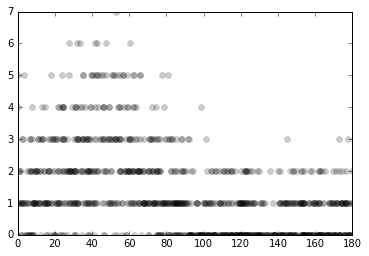

In [14]:
plt.plot(ori, Y, 'ko', alpha=0.2)
plt.show()

In [16]:
#from sklearn.cross_validation import train_test_split
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X = Xgrating_vgg
#X = Xplain_vgg
ori_train = ori[0:800]
ori_test = ori[800:1000]

X_train = X[0:800, :]
X_test = X[800:1000, :]

Y_train = Y[0:800]
Y_test = Y[800:1000]


### Fit VGG models to simulated neuron

In [17]:
hidden_dim = 100

keras_glm_model = V4.keras_GLM(X.shape[1], hidden_dim, learning_rate=0.01)
#keras_glm_model = V4.keras_GLM(X.shape[1], hidden_dim)
keras_glm_model.fit(X, Y, batch_size=128, nb_epoch=50, verbose=True)

Y_train_hat = keras_glm_model.predict(X_train)
Y_test_hat = keras_glm_model.predict(X_test)

pseudo_R2_train = V4.poisson_pseudo_R2(np.squeeze(Y_train), np.squeeze(Y_train_hat), np.mean(Y_train))
pseudo_R2_test = V4.poisson_pseudo_R2(np.squeeze(Y_test), np.squeeze(Y_test_hat), np.mean(Y_train))
pseudo_R2_train, pseudo_R2_test

Epoch 1/50
1000/1000 [==============================] - 0s - loss: 1.1113     
Epoch 2/50
1000/1000 [==============================] - 0s - loss: 1.0163     
Epoch 3/50
1000/1000 [==============================] - 0s - loss: 0.9993     
Epoch 4/50
1000/1000 [==============================] - 0s - loss: 0.9956     
Epoch 5/50
1000/1000 [==============================] - 0s - loss: 0.9865     
Epoch 6/50
1000/1000 [==============================] - 0s - loss: 0.9771     
Epoch 7/50
1000/1000 [==============================] - 0s - loss: 0.9775     
Epoch 8/50
1000/1000 [==============================] - 0s - loss: 0.9757     
Epoch 9/50
1000/1000 [==============================] - 0s - loss: 0.9775     
Epoch 10/50
1000/1000 [==============================] - 0s - loss: 0.9718     
Epoch 11/50
1000/1000 [==============================] - 0s - loss: 0.9672     
Epoch 12/50
1000/1000 [==============================] - 0s - loss: 0.9689     
Epoch 13/50
1000/1000 [==========================

(0.064084282617401622, 0.052797799066232942)

In [18]:
Y_train_hat.shape

(800, 1)

In [19]:
covars_train = covars[0:800]
covars_test = covars[800:1000]

glm.fit(covars_train, Y_train)
Y_test_hat2 = glm[-1].predict(covars_test)

/opt/anaconda/anaconda2/lib/python2.7/site-packages/pyglmnet-0.1.dev0-py2.7.egg/pyglmnet/pyglmnet.py:435: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/anaconda/anaconda2/lib/python2.7/site-packages/pyglmnet-0.1.dev0-py2.7.egg/pyglmnet/pyglmnet.py:455: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/anaconda/anaconda2/lib/python2.7/site-packages/pyglmnet-0.1.dev0-py2.7.egg/pyglmnet/pyglmnet.py:460: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


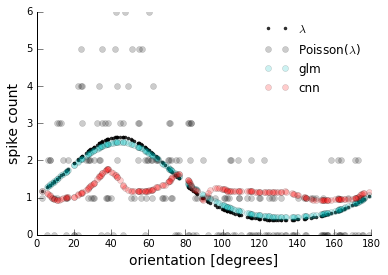

In [20]:
plt.figure()
ax = plt.subplot(111)
ax.plot(ori_test, np.dot(np.exp(covars_test), beta), 'k.', alpha=0.8)
ax.plot(ori_test, Y_test, 'ko', alpha=0.2)
ax.plot(ori_test, Y_test_hat2, 'co', alpha=0.2)
ax.plot(ori_test, Y_test_hat, 'ro', alpha=0.2)
V4.simpleaxis(ax)

plt.legend(['$\lambda$', 'Poisson($\lambda$)', 'glm', 'cnn'], frameon=False)
plt.xlabel('orientation [degrees]', fontsize=14)
plt.ylabel('spike count', fontsize=14)
plt.savefig('../04-figures_cosyne2017/orientation_simulation_l8.pdf', format='pdf')
plt.show()

### Design artificial stimuli and compute convnet codebooks

#### Orientation

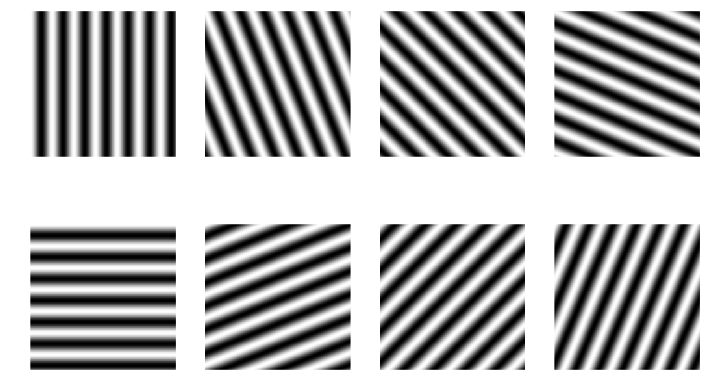

In [22]:
def make_sine_grating(n_pixels=224, theta=0, spatial_freq=0.03, phase=0):
    
    # Design the grating
    [x, y] = np.meshgrid(np.arange(n_pixels), np.arange(n_pixels))
    theta = 180. - theta
    x_theta = x * np.cos(theta / 180. * np.pi) + y * np.sin(theta / 180. * np.pi)
    y_theta = -x * np.sin(theta / 180. * np.pi) + y * np.cos(theta / 180. * np.pi)
    grating = (1. + np.cos(2 * np.pi * spatial_freq * x_theta + phase / 180. * np.pi))/ 2.
    
    # Make it into an image
    G = np.zeros((n_pixels, n_pixels, 3))
    G[:, :, 0] = grating * 255.
    G[:, :, 1] = grating * 255.
    G[:, :, 2] = grating * 255.    
    return np.uint8(G)


angles = [0.,   22.,   45.,   67.,   90.,  112.,  135.,  157.]
#angles = np.linspace(0., 179.0, num=90.)
#phases = 360. * np.random.rand(90)
phases = np.zeros(90)
plt.figure(figsize=(12,7))

# Extract vgg features for oriented gratings
Xgrating_vgg = list()
for a, ang in enumerate(angles):
    G = make_sine_grating(theta=angles[a], phase=phases[a])
    G_for_vgg = V4.prepare_image_for_vgg(G)
    Xgrating_vgg.append(np.squeeze(vgg_model.predict(G_for_vgg)))
    
    plt.subplot(2, 4, a + 1)
    plt.imshow(G, interpolation='none')
    plt.axis('off')
plt.savefig('../04-figures_cosyne2017/example_orientation_stimuli.pdf', format='pdf')
plt.show()
Xgrating_vgg = np.array(Xgrating_vgg)

In [227]:
Xgrating_vgg.shape

(90, 1000)

#### Hue

In [68]:
Xplain_vgg = list()
stimpath = '../V4pydata'

angles = np.arange(0, 360, 4)

for stim_id in angles:
    imname = '/stimuli/M3/Hues/img%03d.jpg' % stim_id
    filename = stimpath + imname
    I = cv2.imread(filename)
    I_for_vgg = V4.prepare_image_for_vgg(I)
    Xplain_vgg.append(np.squeeze(vgg_model.predict(I_for_vgg)))
Xplain_vgg = np.array(Xplain_vgg)

In [69]:
Xplain_vgg.shape

(90, 25088)

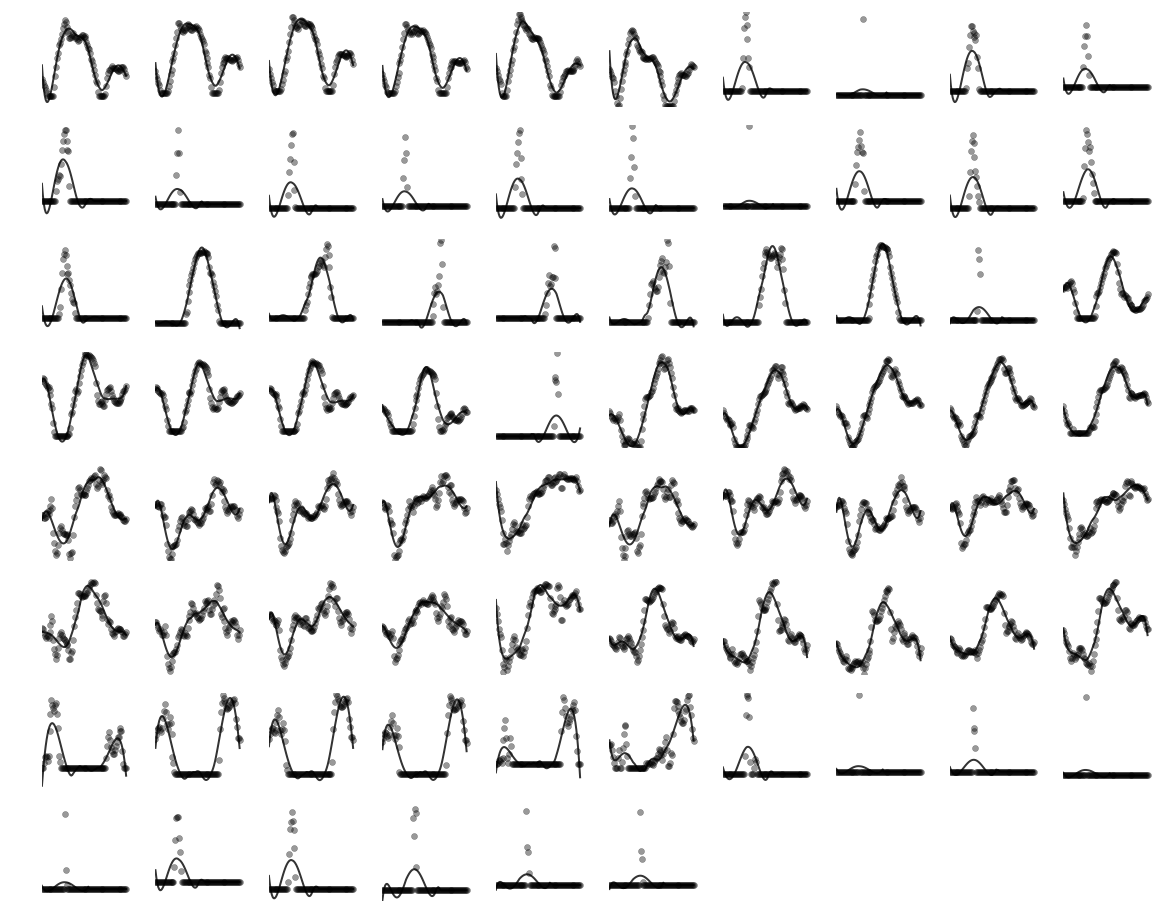

mean +/ std: 0.52 +/- 0.15 (N = 2052)


In [77]:
from scipy.signal import savgol_filter

u_start, u_end = 2500, 2900
window = 51
order = 5
plot_idx = 1
plt.figure(figsize=(20,20))
for u in range(u_start, u_end):
    #tune = Xgrating_vgg[:, u]
    tune = Xplain_vgg[:, u]
    if np.all(tune == 0):
        continue
    else:
        ax = plt.subplot(10, 10, plot_idx)
        ax.plot(angles, tune, 'ko', alpha=0.4)
        ax.plot(angles, savgol_filter(tune, 51, 5), 'k-', alpha=0.8, lw=2)
        V4.simpleaxis(ax)
        circ_mode_score = 0.5 * (get_mode_score(tune, window, order) + 
                                 get_mode_score(np.roll(tune, 45), window, order))
        #plt.title('%4.2f' % circ_mode_score)
        plt.axis('off')
        plot_idx += 1
plt.savefig('../04-figures_cosyne2017/vgg16_hue_tuning_l5.pdf', format='pdf')
plt.show()

score = list()
#for u in range(Xgrating_vgg.shape[1]):
for u in range(Xplain_vgg.shape[1]):
    #tune = Xgrating_vgg[:, u]
    tune = Xplain_vgg[:, u]
    if np.all(tune == 0):
        continue
    else:
        circ_mode_score = 0.5 * (get_mode_score(tune, window, order) + 
                                 get_mode_score(np.roll(tune, 45), window, order))
        score.append(circ_mode_score)
score = np.array(score)
print('mean +/ std: %4.2f +/- %4.2f (N = %d)' % (np.nanmean(score), np.nanstd(score), len(score)))


### compute a heuristic estimator of number of modes

In [25]:
def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):

    """Detect peaks in data based on their amplitude and other features.

    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height.
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.

    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`
    
    The function can handle NaN's 

    See this IPython Notebook [1]_.

    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)

    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=0, mpd=20, valley=True, show=True)

    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)

    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)
    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind


def _plot(x, mph, mpd, threshold, edge, valley, ax, ind):
    """Plot results of the detect_peaks function, see its help."""
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(8, 4))

        ax.plot(x, 'b', lw=1)
        if ind.size:
            label = 'valley' if valley else 'peak'
            label = label + 's' if ind.size > 1 else label
            ax.plot(ind, x[ind], '+', mfc=None, mec='r', mew=2, ms=8,
                    label='%d %s' % (ind.size, label))
            ax.legend(loc='best', framealpha=.5, numpoints=1)
        ax.set_xlim(-.02*x.size, x.size*1.02-1)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax.set_xlabel('Data #', fontsize=14)
        ax.set_ylabel('Amplitude', fontsize=14)
        mode = 'Valley detection' if valley else 'Peak detection'
        ax.set_title("%s (mph=%s, mpd=%d, threshold=%s, edge='%s')"
                     % (mode, str(mph), mpd, str(threshold), edge))
        # plt.grid()
        plt.show()



In [26]:
def get_mode_score(tune, window=51, order=5, show=False):
    tune_hat = savgol_filter(tune, window, order)
    max_tune_hat = tune_hat.max()
    peaks = detect_peaks(tune_hat, mpd=10, show=show)
    valleys = detect_peaks(tune_hat, mpd=10, valley=True, show=show)
    critical_points = np.sort(np.concatenate((peaks, valleys)))
    #print critical_points
    tuning_at_critical_points = tune_hat[critical_points]
    #print tuning_at_critical_points
    mode_score = 0.
    mode_score += 0.5 * np.mean(np.abs(np.diff(tuning_at_critical_points))) 
    mode_score += 0.5 * np.mean(np.abs(np.diff(tuning_at_critical_points[::-1])))
    mode_score /= (np.max(tune_hat) - np.min(tune_hat))
    return mode_score

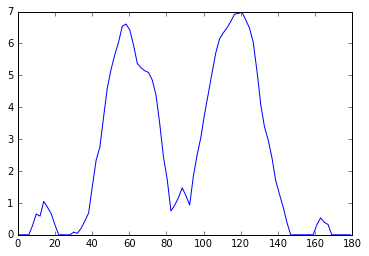

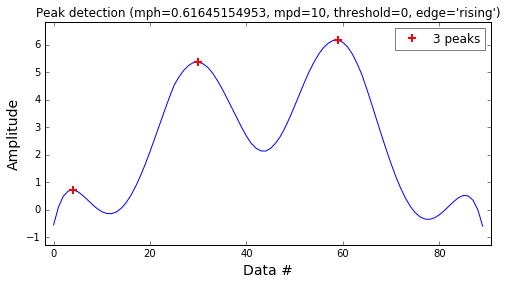

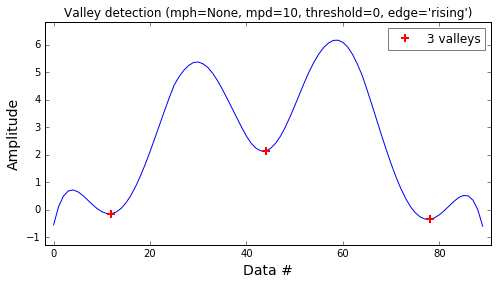

[ 4 12 30 44 59 78]
[ 0.72193193 -0.13994555  5.37222052  2.13433051  6.1645155  -0.34570646]


In [127]:
tune = Xgrating_vgg[:, 2501]
plt.plot(angles, tune)
get_mode_score(tune, show=True)
plt.show()

In [78]:
score.shape

(2052,)